In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" # difference between gpu '0' and '1'

"""
# for reproducibility with server...

os.environ["PYTHONHASHSEED"] = "0"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1" # setting "true"
os.environ["TF_DETERMINISTIC_OPS"] = "1"
"""

import numpy as np
import tensorflow as tf2
import random
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

import scipy.io
from sklearn.decomposition import PCA
import pdb

import pandas as pd
import scanpy as sc


import scipy.sparse
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy import stats 
from scipy import * 
import datetime 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

os.getpid()


2023-05-10 14:52:00.178205: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-10 14:52:01.003549: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Instructions for updating:
non-resource variables are not supported in the long term


316196

In [2]:
#tf.enable_eager_execution()
np.random.seed(0)
#tf.set_random_seed(0)
tf.set_random_seed(0)
random.seed(0)
tf2.random.set_seed(0)
tf2.keras.utils.set_random_seed(0)
#tf.keras.utils.set_random_seed(0)

In [3]:
# Global Variables
dataset_name = 'Pancreas'#'Simulation' # 'Pancreas' # 'Lung', Pancreas2 #sim_full, Immune, sim2, simulation2, Simulation2, "Pan", Human_Retina
category = 9 #6 for simulation # 3 for pancreas, 16 for lung, 10 for Immune, 6, 4 Simulation2, 9 for Pan, 30 for human retina

hvg = 2000
#hvg = 720

In [4]:
print (tf.__version__) #1.15.2

2.12.0


In [5]:

import warnings
warnings.filterwarnings('ignore')


In [6]:
#path = '/content/drive/My Drive/Colab Notebooks/Project/advVAE/'
path = "../../"
#path = '/home/ajita/Documents/IITK_AS/DI/SCRNA_Datasets/'

In [7]:
# Utility functions
# Util.py .....
def read_mtx(filename, trans_flag = False):
     buffer = scipy.io.mmread(filename)

     if trans_flag:
         print('Transpose Data !')
         return buffer.transpose()
     else:
         return buffer

def write_mtx(filename, data):
    scipy.io.mmwrite(filename, data)

# Leaky Relu
def lrelu(x, alpha = 0.2, name='lrelu'):
    return tf.maximum(x, alpha*x)

def dense(x, inp_dim, out_dim, name = 'dense'):

    with tf.variable_scope(name, reuse=None): # earlier only tf
        weights = tf.get_variable("weights", shape=[inp_dim, out_dim],
                                  initializer = tf2.initializers.GlorotUniform()) # contrib: tf.contrib.layers.xavier_initializer()
        
        bias = tf.get_variable("bias", shape=[out_dim], initializer = tf.constant_initializer(0.0))
        
        # initializer= tf2.initializers.GlorotUniform(); same as Xavier's initializer; tf.contrib.layers.xavier_initializer()    
        out = tf.add(tf.matmul(x, weights), bias, name='matmul')
        return out


In [8]:

def read_npy():
    batch_info = np.load(path + 'Pancreas_/accessions.npy')
    features = np.load(path + 'Pancreas_/features.npy')
    labels = np.load(path + 'Pancreas_/labels.npy')

    batch_info = np.array([[i] for i in batch_info])

    Ann = sc.AnnData(pd.DataFrame(features))
    sc.pp.log1p(Ann)

    sc.pp.highly_variable_genes(
        Ann, 
        flavor="seurat", 
        n_top_genes = 2000, # 721
        subset=True)

    df_final = pd.DataFrame(Ann.X).reset_index(drop = True)
    data = df_final[df_final.columns[:2000]].to_numpy()
    return data

def read_h5ad(data_path, B, C):
    Ann = sc.read_h5ad(data_path)
    Ann.layers["counts"] = Ann.X.copy()

    sc.pp.normalize_total(Ann, target_sum=1e4)
    sc.pp.log1p(Ann)
    Ann.raw = Ann 
    
    sc.pp.highly_variable_genes(
        Ann, 
        flavor="seurat", 
        n_top_genes=hvg,
        batch_key=B,
        subset=True)
  
    #df_final = pd.DataFrame.sparse.from_spmatrix(Ann.X) # Lung, Simulation1, Simulation 2
    df_final = pd.DataFrame(Ann.X) # Immune , Pan

    df_final = df_final.reset_index(drop = True)
    data = df_final.to_numpy()
    labels = Ann.obs[C].to_list()

    #AJ: Convert to categorical instead of this...
    t_ = Ann.obs[B] #.to_list()
    batch_info = np.array([[i] for i in t_]) # for other datasets

    #batch_info = np.array(Ann.obs[B].astype("category").reset_index(drop = True)).reshape(-1,1) 
    enc = OneHotEncoder(handle_unknown='ignore')
    #batch_info_enc = enc.fit_transform(batch_info).toarray()
  
    enc.fit(batch_info.reshape(-1, 1))
    batch_info_enc = enc.transform(batch_info.reshape(-1, 1)).toarray()

    #print ('batches', batch_info_enc)
    #print ('labels:', labels)

    #print ('batch info', np.unique(batch_info))
    #print ('labels:', labels)
    return data, labels, batch_info_enc, batch_info

In [9]:


def load_gene_mtx(dataset_name, transform = True, count = True, actv = 'sig'):

    # for CSV files...
    if (dataset_name == 'Pan'):
        df_final = pd.read_csv(path + 'Pancreas' +'/pancreas_mat_processed.csv') #_2000
        df_final = df_final.iloc[:, :-1]
        data = df_final.to_numpy()
        
        data_path = path + dataset_name + '/labels.csv' 
        labels = pd.read_csv(data_path, header = None)
       
    # for npy format files...
    elif (dataset_name in ('Pancreas_', 'Pancreas1', 'Pancreas2', 'Pancreas3', 'Pancreas4', 'Pancreas5', 'Pancreas6', 'Pancreas7')):
        data = read_npy()

    # for h5ad format files...
    elif (dataset_name in ('Lung', 'Immune', 'sim_full', 'Simulation2', 'Pancreas', 'Human_Retina')):

        if (dataset_name == 'Lung'):
            data_name = 'Lung/Lung_atlas_public.h5ad' #Lung_atlas_public, Lung
            B = 'batch'
            C = 'cell_type'

        elif (dataset_name == 'Immune'):
            data_name = 'Immune/Immune_ALL_human.h5ad' 
            B = 'batch'
            C = 'final_annotation'

        elif (dataset_name == 'sim_full'):
            data_name = 'Simulation/sim1_full.h5ad' 
            B = 'Batch'
            C = 'Group' 

        elif (dataset_name == 'Simulation2'):
            data_name = 'Simulation2/sim2.h5ad' 
            B = 'Batch'
            C = 'Group'

        elif (dataset_name == "Pancreas"):
            data_name = "Pancreas/Pancreas.h5ad"
            B = "tech"
            C = "celltype"

        elif (dataset_name == "Human_Retina"):
            data_name = "Human_Retina/Human_Retina.h5ad"
            B = "Batch"
            C = "Subcluster"

        data, labels, batch_info_enc, batch_info = read_h5ad(path + data_name, B, C)
         
    else:

        data_path = path + dataset_name +'/sub_set-720.mtx'
        data = scipy.io.mmread(data_path) #read_mtx
       
        data_path = path + dataset_name + '/labels.txt'
        labels = np.loadtxt(data_path)
        
    '''
    if dataset_name in ('Pancreas'):
        data_path = path + dataset_name + '/tech.csv' 
        t_labels = pd.read_csv(data_path, header = None)
        t_labels = t_labels.reset_index(drop = True) 
        batch_info = t_labels.to_numpy()
        print ('batch info', batch_info)

        enc = OneHotEncoder(handle_unknown='ignore')
        #batch_info_enc = enc.fit_transform(batch_info).toarray()
  
        enc.fit(batch_info.reshape(-1, 1))
        batch_info_enc = enc.transform(batch_info.reshape(-1, 1)).toarray()
    ''' 
    print ('Shape of data is: ', data.shape)

    if transform:
        data = transform_01_gene_input(data)
        print('Data Transformed, entries in [0, 1] !'.format(data_path))
    else:
        if count == False:
            data = np.log2(data+1)

            if actv == 'lin':
                scale = 1.0
            else:
                scale = np.max(data)
            data = data / scale           

    ord_enc = LabelEncoder()
    labels  = ord_enc.fit_transform(labels)
    print ('here', labels)

    unique, counts = np.unique(labels, return_counts = True)
    dict(zip(unique, counts))
    
    total_size = data.shape[0]

    if count == False:
        return data, data, scale, labels, labels, batch_info_enc, batch_info_enc, batch_info

    return data, data, labels, labels, labels


Class **Functions**

Building model

In [10]:
# Class Functions:
def build_model(self):

    self.N_batch = category
    self.x_input = tf.placeholder(dtype=tf.float32, shape=[None, self.X_dim], name='Input')
    self.x_input_ = tf.placeholder(dtype=tf.float32, shape=[None, self.X_dim], name='Input')
    self.x_target = tf.placeholder(dtype=tf.float32, shape=[None, self.X_dim], name='Target')
    self.batch_input = tf.placeholder(dtype = tf.float32, shape=[None, self.N_batch], name='batch_input') # 6, 3
    self.batch_input_ = tf.placeholder(dtype = tf.float32, shape=[None, self.N_batch], name='batch_input')
    
    self.keep_prob = tf.placeholder(dtype=tf.float32, name = 'keep_prob')
    self.real_distribution = tf.placeholder(dtype=tf.float32, shape=[None, self.z_dim], name='Real_distribution')
    self.kl_scale = tf.placeholder(tf.float32, (), name='kl_scale')
    
    self.kl_scale = 0.001 # 0.01, 0, 0.001
    self.dropout_rate = 0.1
    self.training_phase = True 
    self.n_layers = self.num_layers 
    self.n_latent = self.z_dim
    
    # AJ
    self.enc_input = tf.concat([self.x_input, self.batch_input],1)
    self.enc_input_ = tf.concat([self.x_input_, self.batch_input_],1)
    print('encoder input shape ',self.enc_input)

    # AJ: Encoder output...
    self.encoder_output, self.z_post_m, self.z_post_v, self.l_post_m, self.l_post_v = self.encoder(self.enc_input) # self.x_input
    self.encoder_output_, self.z_post_m_, self.z_post_v_, self.l_post_m_, self.l_post_v_ = self.encoder(self.enc_input_, reuse = True) 

    self.expression = self.x_input               
    self.proj = tf.placeholder(dtype=tf.float32, shape=[None, self.X_dim], name='projection')
  
    log_library_size = np.log(np.sum(self.data_train, axis=1)) 
    mean, variance = np.mean(log_library_size), np.var(log_library_size)

    library_size_mean = mean
    library_size_variance = variance
    self.library_size_mean = tf.to_float(tf.constant(library_size_mean))
    self.library_size_variance = tf.to_float(tf.constant(library_size_variance))    
    
    self.z = self.sample_gaussian(self.z_post_m, self.z_post_v) 
    self.z_ = self.sample_gaussian(self.z_post_m_, self.z_post_v_) 

    self.library = self.sample_gaussian(self.l_post_m, self.l_post_v)
    
    # AJ
    #self.decoder_output = self.decoder(self.z)  
    print('decoder input shape ',tf.concat([self.z, self.batch_input],1))

    self.decoder_output = self.decoder(tf.concat([self.z, self.batch_input],1))             
    self.n_input = self.expression.get_shape().as_list()[1]
  
    self.x_post_scale = tf.nn.softmax(dense(self.decoder_output, self.g_h_dim[0], self.n_input, name='dec_x_post_scale')) 
    self.x_post_r = tf.Variable(tf.random_normal([self.n_input]), name="dec_x_post_r")           
    self.x_post_rate = tf.exp(self.library) * self.x_post_scale
    self.x_post_dropout = dense(self.decoder_output, self.g_h_dim[0], self.n_input, name='dec_x_post_dropout') 
        
    local_dispersion = tf.exp(self.x_post_r)            
    local_l_mean = self.library_size_mean
    local_l_variance = self.library_size_variance

    self.decoder_output2 = tf.nn.sigmoid(dense(self.decoder_output, self.g_h_dim[0], self.X_dim, 'dec_output2'))  
    
    # Discriminator D1....
    self.dis_real_logit = self.discriminator(self.real_distribution, self.z_dim) # random z from Gaussina distribution ...
    self.dis_fake_logit = self.discriminator(self.z, self.z_dim, reuse=True)  # z distribution coming from encoder...network 
    
    # Discriminator D2
    self.dis2_real_logit = self.discriminator2(self.x_target, self.X_dim) # True data
    self.dis2_fake_logit = self.discriminator2(self.decoder_output2, self.X_dim, reuse=True) # from decoder network
    
    # Discriminator D_batch : discriminate between different batches info
    # pass the encoded data; self.x_target, self.X_dim
    self.disb_real_logit = self.discriminatorB(self.z, self.z_dim) # True data
    
    # Reconstruction loss 
    capL = 1e-4 #1e-8
    capU = 1e4 #1e8

    #recon_loss = 0
    recon_loss = self.zinb_model(self.expression, self.x_post_rate, local_dispersion, self.x_post_dropout)
    #recon_loss = tf.reduce_mean(tf.square(tf.subtract( self.decoder_output2, self.x_input)))
    
    self.kl_gauss_l = 0.5 * tf.reduce_sum(- tf.log(tf.math.minimum(tf.math.maximum(self.l_post_v, capL), capU))  \
                                      + self.l_post_v/local_l_variance \
                                      + tf.square(self.l_post_m - local_l_mean)/local_l_variance  \
                                      + tf.log(tf.math.minimum(tf.math.maximum(local_l_variance, capL), capU)) - 1, 1)

    self.kl_gauss_z = 0.5 * tf.reduce_sum(- tf.log(tf.math.minimum(tf.math.maximum(self.z_post_v, capL), capU)) + self.z_post_v + tf.square(self.z_post_m) - 1, 1)

    print ('KL gaussian z', self.kl_gauss_z)
    print ('KL gaussian l', self.kl_gauss_l)

    # Evidence lower bound - ELBO : KLscale to prevent posterior collapse...
    #self.ELBO_gauss = tf.reduce_mean(recon_loss - self.kl_gauss_l - self.kl_scale * self.kl_gauss_z) - tf.reduce_sum(tf.pow(self.z - self.z_, 2)) 
    self.ELBO_gauss = tf.reduce_mean(recon_loss - self.kl_scale*self.kl_gauss_l - self.kl_scale*self.kl_gauss_z) - self.kl_scale*tf.reduce_sum(tf.pow(self.z - self.z_, 2)) 

    #tf.reduce_sum(tf.math.sqrt(self.z - self.z_)) #tf.reduce_sum(tf.pow(self.z - self.z_, 2))
    
    # - is added to ELBO because we maximize the ELBO expression & maximize classifier cross entropy loss -> -loss minimize cross entropy
    self.autoencoder_loss = - self.ELBO_gauss - tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = self.disb_real_logit, labels = self.batch_input)) - tf.log(tf.math.minimum(tf.math.maximum(tf.reduce_sum(tf.sqrt(tf.abs(self.dis2_real_logit/tf.reduce_sum(self.dis2_real_logit)* self.dis2_fake_logit/tf.reduce_sum(self.dis2_fake_logit)))), capL), capU))                    
          
    # Discriminator D1: minimize distance   min max objective function - BD distance between z (random sample) and generated z sample from encoder
    self.dis_loss = - tf.log(tf.math.minimum(tf.math.maximum(tf.reduce_sum(tf.sqrt(tf.abs(self.dis_real_logit/tf.reduce_sum(self.dis_real_logit)
                                        * self.dis_fake_logit/tf.reduce_sum(self.dis_fake_logit)))), capL), capU)) 
            
    # Discriminator D2: minimize distance min max objective function - BD distance between X(generated sample) and X input 
    self.dis2_loss = tf.log(tf.math.minimum(tf.math.maximum(tf.reduce_sum(tf.sqrt(tf.abs(self.dis2_real_logit/tf.reduce_sum(self.dis2_real_logit)
                                        * self.dis2_fake_logit/tf.reduce_sum(self.dis2_fake_logit)))), capL), capU)) # epsilon added to avoid Nan
    
    # Generator loss - D(z) {D(E(X_real))}  - D1 label will be 1; they are trying to maximize the 
    self.generator_loss = - tf.log(tf.math.minimum(tf.math.maximum(tf.reduce_sum(tf.sqrt(tf.abs(self.dis_fake_logit/tf.reduce_sum(self.dis_fake_logit)) )), capL), capU)) 

            
    # 27Apr: AJ : minimize binary cross entropy     
    self.disb_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = self.disb_real_logit, labels = self.batch_input)) #self.batch_input
    
    t_vars = tf.trainable_variables()
    self.dis_vars = [var for var in t_vars if 'dis_' in var.name]
    self.gen_vars = [var for var in t_vars if 'enc_' in var.name or 'dec_' in var.name] #AS:2109

    # Discriminator D2
    self.dis2_vars = [var for var in t_vars if 'dis2_' in var.name] #or 'enc_' in var.name or 'dec_' in var.name]
    
    # Discriminator DB: AJ
    #self.disb_vars = [var for var in t_vars if 'disb_' in var.name]
    self.disb_vars = [var for var in t_vars if 'disb_' in var.name ]

    self.saver = tf.train.Saver()


Training 

In [11]:
def train_cluster(self):

    print('Cluster DRA on DataSet {} ... '.format(self.dataset_name))

    #tf.train.Optimizer
    #autoencoder_optimizer = tf.keras.optimizers.SGD(learning_rate=0.1).minimize(self.autoencoder_loss, var_list = self.gen_vars)
    #autoencoder_optimizer = tf.train.GradientDescentOptimizer(learning_rate = self.lr).minimize(self.autoencoder_loss)

    # learning_rate=self.lr,beta1=self.beta1 #0.0002
    autoencoder_optimizer = tf.train.AdamOptimizer(learning_rate=0.0002,beta1=self.beta1).minimize(self.autoencoder_loss) # self.disb_vars, var_list = self.gen_vars

    # Not used at the moment....
    #autoencoder_optimizer2 = tf.train.AdamOptimizer(learning_rate=self.lr,
    #                                               beta1=self.beta1).minimize( self.autoencoder_loss) # self.disb_vars

    discriminator_optimizer = tf.train.AdamOptimizer(learning_rate=self.lr,
                                                      beta1=self.beta1).minimize(self.dis_loss,
                                                                                  var_list=self.dis_vars)
    generator_optimizer = tf.train.AdamOptimizer(learning_rate=self.lr,
                                                  beta1=self.beta1).minimize(self.generator_loss,var_list=self.gen_vars)
    # Discriminator D2
    discriminator2_optimizer = tf.train.AdamOptimizer(learning_rate=self.lr,
                                                      beta1=self.beta1).minimize(self.dis2_loss,
                                                                                  var_list=self.dis2_vars)
    
    # Discriminator batch: Classifier....
    
    discriminatorb_optimizer = tf.train.AdamOptimizer(learning_rate = self.lr,
                                              beta1 = self.beta1).minimize(self.disb_loss, var_list = self.disb_vars)
    
    self.sess.run(tf.global_variables_initializer())
    a_loss_epoch = []
    d_loss_epoch = []
    g_loss_epoch = []
    d2_loss_epoch = [] # Discriminator D2
    db_loss_epoch = [] # Discriminator batch

    control = 3 # Generator is updated twice for each Discriminator D1 update

    num_batch_iter = self.total_size // self.batch_size
    #indices = np.arange(self.data_train.shape[0])
    
    for ep in range(self.epoch):
    #for it in range(num_batch_iter):
    
        d_loss_curr = g_loss_curr = a_loss_curr = np.inf
        self._is_train = True

        #index = 0
        #np.random.shuffle(indices)
        
        for it in range(num_batch_iter):

            # Selecting mini batch
            """
            batch_indices = indices[index : index + self.batch_size]
            
            batch_x = self.data_train[batch_indices, :]
            X_ = self.batch_train[batch_indices, :]
            #labels_ = self.labels_enc[batch_indices, :]
            #labels_n = self.labels_na[batch_indices]            
            index += self.batch_size
            """
            batch_x, X_ = self.next_batch(self.data_train, self.batch_train, self.train_size)

            df = pd.DataFrame(batch_x)
            col = df.columns[:100] # random col generate
            for c in col: #[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
                df[c] = 0
            
            batch_x_ = df.to_numpy()

            # Random Sampling for the batch size...
            batch_z_real_dist = self.sample_Z(self.batch_size, self.z_dim)

            _, a_loss_curr = self.sess.run([autoencoder_optimizer, self.autoencoder_loss],
                                            feed_dict={self.x_input: batch_x, self.x_target: batch_x, 
                                                       self.x_input_: batch_x_, self.batch_input_: X_,
                                                      self.batch_input: X_, # batch_b
                                                      self.keep_prob: self.keep_param}) 
  
                
            #if np.mod(it, control) == 0: 

            '''
            _, d_loss_curr = self.sess.run([discriminator_optimizer, self.dis_loss],
                feed_dict={self.x_input: batch_x,
                            self.batch_input: X_,
                self.real_distribution: batch_z_real_dist,
                self.x_input_: batch_x_, self.batch_input_: X_,
                self.keep_prob: self.keep_param})    
            '''
            
            '''                                          
            else: 
                
                _, g_loss_curr = self.sess.run([generator_optimizer, self.generator_loss], 
                    feed_dict={self.x_input: batch_x, self.x_target: batch_x, self.keep_prob: self.keep_param, 
                               self.x_input_: batch_x_, self.batch_input_: X_,
                               self.batch_input: X_, self.real_distribution: batch_z_real_dist}) #self.generator_loss
            '''
            
            # AJ: Count here, D2 is taking true data only.
            _, d2_loss_curr = self.sess.run([discriminator2_optimizer, self.dis2_loss],
                        feed_dict={self.x_input: batch_x,
                        self.x_target: batch_x,
                        self.batch_input: X_,
                        self.real_distribution: batch_z_real_dist,
                        self.x_input_: batch_x_, self.batch_input_: X_,
                        self.keep_prob: self.keep_param}) 
            
            _, db_loss_curr = self.sess.run([discriminatorb_optimizer, self.disb_loss],
                feed_dict={self.x_input: batch_x,
                            self.batch_input: X_,
                self.real_distribution: batch_z_real_dist,
                self.batch_input: X_, # batch_b
                self.x_input_: batch_x_, self.batch_input_: X_,
                self.keep_prob: self.keep_param})
            
            
        #db_loss_curr = 0
        print("Epoch : [%d] ,  a_loss = %.4f, d_loss: %.4f ,  g_loss: %.4f,  db_loss: %.4f" 
              % (ep, a_loss_curr, d_loss_curr, g_loss_curr,db_loss_curr))
        
        
        self._is_train = False # enables false after 1st iterations only...to make training process fast

        if (np.isnan(a_loss_curr) or np.isnan(d_loss_curr) or np.isnan(g_loss_curr) or np.isnan(db_loss_curr)): # np.isnan(d2_loss_curr)
          a_loss_curr = 0
          d_loss_curr = 0
          g_loss_curr = 0
          d2_loss_curr = 0
          db_loss_curr = 0
          break

        #self.x_target: batch_x,
        a_loss_epoch.append(a_loss_curr) # total loss getting appended 
        d_loss_epoch.append(d_loss_curr)
        g_loss_epoch.append(g_loss_curr)
        #d2_loss_epoch.append(d2_loss_curr)
        db_loss_epoch.append(db_loss_curr)
        
        if (ep % 50 == 0):
            self.eval_cluster_on_test_(ep)

    self.eval_cluster_on_test(ep)

Encoder

In [12]:
# reuse = False

def encoder(self, x, reuse = False):
    """
    Encode part of the autoencoder.
    :param x: input to the autoencoder
    :param reuse: True -> Reuse the encoder variables, False -> Create or search of variables before creating
    :return: tensor which is the hidden latent variable of the autoencoder.
    """

    with tf.variable_scope('Encoder') as scope:
        if reuse:
            scope.reuse_variables()

        if self.is_bn:
            h = tf.layers.batch_normalization(

                lrelu(dense(x, self.X_dim + self.N_batch, self.g_h_dim[0], name='enc_h0_lin'), alpha=self.leak),
                training=self._is_train, name='enc_bn0')
                
            for i in range(1, self.num_layers):
                h = tf.layers.batch_normalization(

                    lrelu(dense(h, self.g_h_dim[i - 1], self.g_h_dim[i], name='enc_h' + str(i) + '_lin'),
                          alpha=self.leak),
                    training=self._is_train, name='enc_bn' + str(i))                    

            z_post_m = dense(h, self.g_h_dim[self.num_layers - 1], self.z_dim, name='enc_z_post_m' + str(self.num_layers) + '_lin')                
            z_post_v = tf.exp(dense(h, self.g_h_dim[self.num_layers - 1], self.z_dim, name='enc_z_post_v' + str(self.num_layers) + '_lin'))              
            
            h = tf.nn.relu(dense(h, self.g_h_dim[self.num_layers - 1], self.z_dim, name='enc_h' + str(self.num_layers) + '_lin'))

            l_post_m = dense(h, self.z_dim, 1, name='enc_l_post_m' + str(self.num_layers) + '_lin')                            
            l_post_v = tf.exp(dense(h, self.z_dim, 1, name='enc_l_post_v' + str(self.num_layers) + '_lin')) 
            

        else:

            h = tf.nn.dropout(lrelu(dense(x, self.X_dim + self.N_batch, self.g_h_dim[0], name='enc_h0_lin'), alpha=self.leak),
                              keep_prob=self.keep_prob)                
            
            for i in range(1, self.num_layers):
                
                h = tf.nn.dropout(lrelu(dense(h, self.g_h_dim[i - 1], self.g_h_dim[i], name='enc_h' + str(i) + '_lin'),
                          alpha=self.leak), keep_prob=self.keep_prob)                    

            z_post_m = dense(h, self.g_h_dim[self.num_layers - 1], self.z_dim, name='enc_z_post_m' + str(self.num_layers) + '_lin')                
            z_post_v = tf.exp(dense(h, self.g_h_dim[self.num_layers - 1], self.z_dim, name='enc_z_post_v' + str(self.num_layers) + '_lin'))
            
            
            h = tf.nn.relu(dense(h, self.g_h_dim[self.num_layers - 1], self.z_dim, name='enc_h' + str(self.num_layers) + '_lin'))
                      

            l_post_m = dense(h, self.z_dim, 1, name='enc_l_post_m' + str(self.num_layers) + '_lin')                             
            l_post_v = tf.exp(dense(h, self.z_dim, 1, name='enc_l_post_v' + str(self.num_layers) + '_lin'))                                          
                        
        return h, z_post_m, z_post_v, l_post_m, l_post_v


Discriminator - Z

In [13]:
def discriminator(self, z, z_dim, reuse=False):    
    """
    Discriminator that is used to match the posterior distribution with a given prior distribution.
    :param z: tensor of shape [batch_size, z_dim]
    :param reuse: True -> Reuse the discriminator variables,
                  False -> Create or search of variables before creating
    :return: tensor of shape [batch_size, 1]
    """
    with tf.variable_scope('Discriminator') as scope:
        if reuse:
            scope.reuse_variables()

        if self.is_bn:

            h = tf.layers.batch_normalization(
                lrelu(dense(z, z_dim, self.d_h_dim[self.num_layers - 1], name='dis_h' + str(self.num_layers-1) + '_lin'),      
                      alpha=self.leak),
                training=self._is_train, name='dis_bn' + str(self.num_layers-1))
            for i in range(self.num_layers - 2, -1, -1):
                h = tf.layers.batch_normalization(
                    lrelu(dense(h, self.d_h_dim[i + 1], self.d_h_dim[i], name='dis_h' + str(i) + '_lin'),
                          alpha=self.leak),
                    training=self._is_train, name='dis_bn' + str(i))

        else:

            h = tf.nn.dropout(
                lrelu(dense(z, z_dim, self.d_h_dim[self.num_layers - 1], name='dis_h' + str(self.num_layers-1) + '_lin'),
                      alpha=self.leak),
                keep_prob=self.keep_prob)
            for i in range(self.num_layers - 2, -1, -1):
                h = tf.nn.dropout(
                    lrelu(dense(h, self.d_h_dim[i + 1], self.d_h_dim[i], name='dis_h' + str(i) + '_lin'),
                          alpha=self.leak), keep_prob=self.keep_prob)

        output = dense(h, self.d_h_dim[0], 1, name='dis_output')
        
        return output


Discriminator - X

In [14]:
def discriminator2(self, z, z_dim, reuse=False):    
    """
    Discriminator that is used to match the posterior distribution with a given prior distribution.
    :param z: tensor of shape [batch_size, z_dim]
    :param reuse: True -> Reuse the discriminator variables,
                  False -> Create or search of variables before creating
    :return: tensor of shape [batch_size, 1]
    """
    with tf.variable_scope('Discriminator2') as scope:
        if reuse:
            scope.reuse_variables()

        if self.is_bn:

            h = tf.layers.batch_normalization(
                lrelu(dense(z, z_dim, self.d_h_dim[self.num_layers - 1], name='dis2_h' + str(self.num_layers-1) + '_lin'),      
                      alpha=self.leak),
                training=self._is_train, name='dis2_bn' + str(self.num_layers-1))
            for i in range(self.num_layers - 2, -1, -1):
                h = tf.layers.batch_normalization(
                    lrelu(dense(h, self.d_h_dim[i + 1], self.d_h_dim[i], name='dis2_h' + str(i) + '_lin'),
                          alpha=self.leak),
                    training=self._is_train, name='dis2_bn' + str(i))

        else:

            h = tf.nn.dropout(
                lrelu(dense(z, z_dim, self.d_h_dim[self.num_layers - 1], name='dis2_h' + str(self.num_layers-1) + '_lin'),
                      alpha=self.leak),
                keep_prob=self.keep_prob)
            for i in range(self.num_layers - 2, -1, -1):
                h = tf.nn.dropout(
                    lrelu(dense(h, self.d_h_dim[i + 1], self.d_h_dim[i], name='dis2_h' + str(i) + '_lin'),
                          alpha=self.leak), keep_prob=self.keep_prob)

        output = dense(h, self.d_h_dim[0], 1, name='dis2_output')
        return output



Decoder

In [15]:
def decoder(self, z, reuse=False):
    """
    Decoder part of the autoencoder.
    :param z: input to the decoder
    :param reuse: True -> Reuse the decoder variables, False -> Create or search of variables before creating
    :return: tensor which should ideally be the input given to the encoder.
    """

    with tf.variable_scope('Decoder') as scope:
        if reuse:
            scope.reuse_variables()

        if self.is_bn:

            h = tf.layers.batch_normalization(
              
                lrelu(dense(z , self.z_dim + self.N_batch, self.g_h_dim[self.num_layers-1], name='dec_h' + str(self.num_layers-1) + '_lin'),
                      alpha=self.leak),                   
                training=self._is_train, name='dec_bn' + str(self.num_layers-1))
            for i in range(self.num_layers-2, -1,-1):
                h = tf.layers.batch_normalization(

                    lrelu(dense(h, self.g_h_dim[i + 1], self.g_h_dim[i], name='dec_h' + str(i) + '_lin'),
                          alpha=self.leak),                        
                    training=self._is_train, name='dec_bn' + str(i))
        else:
            h = tf.nn.dropout(lrelu(dense(z, self.z_dim + self.N_batch, self.g_h_dim[self.num_layers-1], name='dec_h' + str(self.num_layers-1) + '_lin'),
                                    alpha=self.leak),                                  
                              keep_prob=self.keep_prob)
            for i in range(self.num_layers-2, -1, -1):
                h = tf.nn.dropout(
                    lrelu(dense(h, self.g_h_dim[i + 1], self.g_h_dim[i], name='dec_h' + str(i) + '_lin'),
                          alpha=self.leak), keep_prob=self.keep_prob)
            
        return h



Classifier

In [16]:
def discriminatorB(self, z, z_dim, reuse = False):    
    
    """
    Discriminator takes the real data and try ti differentiate between different batches
    :param x: tensor of shape [batch_size, x_dim]
    :param batch: tensor of shape [batch_size] -> batchinfo of the train data
    :param reuse: True -> Reuse the discriminator variables,False -> Create or search of variables before creating
    :return: tensor of shape [batch_size, 1]
    """
    '''
    x_ = pd.DataFrame(x.numpy())
    x_ = pd.concat([x_, batch], axis = 1)
    x = torch.tensor(x.values)
    x_dim = torch.tensor(721)
    '''
    
    with tf.variable_scope('discriminatorB') as scope:
        if reuse:
            scope.reuse_variables()

        if self.is_bn:

            h = tf.layers.batch_normalization(
                lrelu(dense(z, z_dim, self.d_h_dim[self.num_layers - 1], name='disb_h' + 
                            str(self.num_layers-1) + '_lin'), alpha = self.leak),
                            training=self._is_train, name='disb_bn' + str(self.num_layers-1))
            
            for i in range(self.num_layers - 2, -1, -1):
                h = tf.layers.batch_normalization(
                    lrelu(dense(h, self.d_h_dim[i + 1], self.d_h_dim[i], name='disb_h' + str(i) + '_lin'),
                          alpha=self.leak),
                    training=self._is_train, name='disb_bn' + str(i))

        else:

            h = tf.nn.dropout(
                lrelu(dense(z, z_dim, self.d_h_dim[self.num_layers - 1], name='disb_h' + str(self.num_layers-1) + '_lin'),
                      alpha=self.leak),
                keep_prob=self.keep_prob)
            
            for i in range(self.num_layers - 2, -1, -1):
                h = tf.nn.dropout(
                    lrelu(dense(h, self.d_h_dim[i + 1], self.d_h_dim[i], name='disb_h' + str(i) + '_lin'),
                          alpha=self.leak), keep_prob=self.keep_prob)

        # AJ 6 in pace of 1 , 3 for pancreas 
        output = dense(h, self.d_h_dim[0], self.N_batch, name='disb_output')
        return output


In [17]:
#AJ: 20 may
# Zero-inflated negative binomial (ZINB) model is for modeling count variables with excessive zeros and it is usually for overdispersed count outcome variables.
def zinb_model(self, x, mean, inverse_dispersion, logit, eps=1e-4): 

    # 1e8 should be of same dimensions as other parameters....                 
    expr_non_zero = - tf.nn.softplus(- logit) \
                    + tf.log(inverse_dispersion + eps) * inverse_dispersion \
                    - tf.log(inverse_dispersion + mean + eps) * inverse_dispersion \
                    - x * tf.log(inverse_dispersion + mean + eps) \
                    + x * tf.log(mean + eps) \
                    - tf.lgamma(x + 1) \
                    + tf.lgamma(x + inverse_dispersion) \
                    - tf.lgamma(inverse_dispersion) \
                    - logit 
    
    expr_zero = - tf.nn.softplus( - logit) \
                + tf.nn.softplus(- logit + tf.log(inverse_dispersion + eps) * inverse_dispersion \
                                  - tf.log(inverse_dispersion + mean + eps) * inverse_dispersion) 

    template = tf.cast(tf.less(x, eps), tf.float32)
    expr =  tf.multiply(template, expr_zero) + tf.multiply(1 - template, expr_non_zero)
    return tf.reduce_sum(expr, axis=-1)

def eval_cluster_on_test_(self, epoch):

    # Embedding points in the test data to the latent space
    inp_encoder = self.data_test
    labels = self.labels_test
    batch_label = self.batch_test
            
    latent_matrix = self.sess.run(self.z, feed_dict = {self.x_input: inp_encoder, self.batch_input: batch_label, self.keep_prob: 1.0})
    
    print ('latent_matrix shape', latent_matrix.shape)
    print (labels.shape)
    
    Ann = sc.AnnData(inp_encoder)
    Ann.obsm['final_embeddings'] = latent_matrix
    Ann.obs['group'] = labels.astype(str)
    
    sc.pp.neighbors(Ann, use_rep = 'final_embeddings') #use_rep = 'final_embeddings'
    sc.tl.umap(Ann)
    img = sc.pl.umap(Ann, color = 'group', frameon = False) # cells
    print(img)
    
    np.savetxt(path + self.dataset_name + '/latent_matrix_c' + str(epoch) +'.csv', latent_matrix, delimiter=",")
    
    Ann.obs['batch'] = self.batch_info.astype(str)
    img2 = sc.pl.umap(Ann, color = 'batch', frameon = False)
    print(img2)

    K = np.size(np.unique(labels))   
    kmeans = KMeans(n_clusters=K, random_state=0).fit(latent_matrix)
    y_pred = kmeans.labels_

    print('Computing NMI ...')
    NMI = nmi(labels.flatten(), y_pred.flatten())
    print('Done !')

    print('NMI = {}'. 
          format(NMI)) 
    
def eval_cluster_on_test(self, epoch):

    # Embedding points in the test data to the latent space
    inp_encoder = self.data_test
    labels = self.labels_test
    batch_label = self.batch_test
            
    latent_matrix = self.sess.run(self.z, feed_dict = {self.x_input: inp_encoder, self.batch_input: batch_label, self.keep_prob: 1.0})
    
    print ('latent_matrix shape', latent_matrix.shape)
    print (labels.shape)
    
    Ann = sc.AnnData(inp_encoder)
    Ann.obsm['final_embeddings'] = latent_matrix
    Ann.obs['group'] = labels.astype(str)
    
    sc.pp.neighbors(Ann, use_rep = 'final_embeddings') #use_rep = 'final_embeddings'
    sc.tl.umap(Ann)
    img = sc.pl.umap(Ann, color = 'group', frameon = False) # cells
    print(img)
    
    np.savetxt(path + self.dataset_name + '/latent_matrix_c' + str(epoch) +'.csv', latent_matrix, delimiter=",")
    
    Ann.obs['batch'] = self.batch_info.astype(str)
    img2 = sc.pl.umap(Ann, color = 'batch', frameon = False)
    print(img2)

    K = np.size(np.unique(labels))   
    kmeans = KMeans(n_clusters=K, random_state=0).fit(latent_matrix)
    y_pred = kmeans.labels_

    print('Computing NMI ...')
    NMI = nmi(labels.flatten(), y_pred.flatten())
    print('Done !')

    print('NMI = {}'. 
          format(NMI)) 

In [18]:
# DRA.py

class Test_DRA(object):
    def __init__(self, sess, epoch = 200, lr=0.0001, beta1=0.5, batch_size=128, X_dim=720, z_dim=10, dataset_name='mnist',
                 checkpoint_dir='checkpoint', sample_dir='samples', result_dir = 'result', num_layers = 2, g_h_dim = None,
                 d_h_dim = None, gen_activation = 'sig', leak = 0.2, keep_param = 1.0, trans = 'sparse',is_bn = False,
                 g_iter = 2, lam=10.0, sampler = 'uniform'):

        self.sess = sess
        self.epoch = epoch
        self.lr = lr
        self.beta1 = beta1
        self.batch_size = batch_size
        self.X_dim = X_dim
        self.z_dim = z_dim
        self.dataset_name = dataset_name
        self.checkpoint_dir = checkpoint_dir
        self.sample_dir = sample_dir
        self.result_dir = result_dir
        self.num_layers = num_layers
        self.g_h_dim = g_h_dim  # Fully connected layers for Generator
        self.d_h_dim = d_h_dim  # Fully connected layers for Discriminator
        self.gen_activation = gen_activation
        self.leak = leak
        self.keep_param = keep_param
        self.trans = trans
        self.is_bn = is_bn
        self.g_iter = g_iter
        self.lam = lam
        self.sampler = sampler
        self.eps = 0.001
        self._is_train = False
        self.n_hidden = 128 
        
        if self.trans == 'sparse':
            self.data_train, self.data_test, self.scale, self.labels_train, self.labels_test, self.batch_train, self.batch_test, self.batch_info = load_gene_mtx(self.dataset_name, transform=False, count=False, actv=self.gen_activation)
            self.N_batch = self.batch_train.shape[1]
        else:
            self.data_train, self.data_test, self.labels_train, self.labels_val, self.labels_test  = load_gene_mtx(self.dataset_name, transform=True)
            self.scale = 1.0
                
        if self.gen_activation == 'tanh':
            self.data = 2* self.data - 1
            self.data_train = 2 * self.data_train - 1
            self.data_val = 2 * self.data_val - 1

        print ('Data set to work on:')
        print (self.data_train)
        print (self.data_train.shape)
        print (self.batch_train)
        print (self.batch_train.shape)
        
        self.train_size = self.data_train.shape[0]
        self.test_size = self.data_test.shape[0]
        self.total_size = self.test_size

        #print("Shape self.data_train:", shape(self.data_train)) 
        #print("Shape self.data_test:", shape(self.data_test)) 
    
        self.build_model()

    build_model = build_model
    train_cluster = train_cluster
    encoder = encoder
    decoder = decoder
    discriminatorB = discriminatorB
    discriminator2 = discriminator2
    discriminator = discriminator
    eval_cluster_on_test = eval_cluster_on_test
    eval_cluster_on_test_ = eval_cluster_on_test_
    zinb_model = zinb_model
    
    
    @property
    def model_dir(self):
        s = "DRA_{}_{}_b_{}_g{}_d{}_{}_{}_lr_{}_b1_{}_leak_{}_keep_{}_z_{}_{}_bn_{}_lam_{}_giter_{}_epoch_{}".format(
            datetime.datetime.now(), self.dataset_name, 
            self.batch_size, self.g_h_dim, self.d_h_dim, self.gen_activation, self.trans, self.lr, 
            self.beta1, self.leak, self.keep_param, self.z_dim, self.sampler, self.is_bn,
            self.lam, self.g_iter, self.epoch) 
        s = s.replace('[', '_')
        s = s.replace(']', '_')
        s = s.replace(' ', '')
        return s

    def sample_Z(self, m, n, sampler='uniform'):
        if self.sampler == 'uniform':
            return np.random.uniform(-1., 1., size=[m, n])
        elif self.sampler == 'normal':
            return np.random.randn(m, n)

    def next_batch(self, data, batch_info, max_size):

        indx = np.random.randint(max_size - self.batch_size)
        return data[indx:(indx + self.batch_size), :], batch_info[indx:(indx + self.batch_size), :]
        

    def next_batch_(self, data, max_size):
        #data = data.sample(frac = 1)
        indx = np.random.randint(max_size - self.batch_size)
        return data[indx:(indx + self.batch_size), :]

    def sample_gaussian(self, mean, variance, scope=None):

        with tf.variable_scope(scope, 'sample_gaussian'):
            sample = tf.random_normal(tf.shape(mean), mean, tf.sqrt(variance))
            sample.set_shape(mean.get_shape())
            return sample



        

In [19]:

#python dra.py --model dra --batch_size 128 --learning_rate 0.0007 --beta1 0.9 --n_l 1 
#--g_h_l1 512 --d_h_l1 512 --bn False --actv sig --trans sparse --keep 0.9 --leak 0.2 --lam 1.0 --epoch 900 --z_dim 10 --train --dataset Simulation

learning_rate = 0.0007 # AJ: 18 may, decrease to address nan issue #0.0007
epoch = 300 # "Epoch to train [25]") # ideal 200 - 2000 v.bary
beta1 = 0.9 # "Momentum term of adam [0.9]")
batch_size = 128 #"The size of batch images [128]")
z_dim = 10 # "Latent space dimension")
n_l = 1 # "# Hidden Layers")
g_h_l1 = 512 #"#Generator Hidden Units in Layer 1")
g_h_l2 = 256 # "#Generator Hidden Units in Layer 2")
g_h_l3 = 0 # "#Generator Hidden Units in Layer 3")
g_h_l4 = 0# "#Generator Hidden Units in Layer 4")
d_h_l1 = 512 # "#Discriminator Hidden Units in Layer 1")
d_h_l2 = 256 # "#Discriminator Hidden Units in Layer 2")
d_h_l3 = 0 #"#Discriminator Hidden Units in Layer 3")
d_h_l4 = 0 #Discriminator Hidden Units in Layer 4")
actv = "sig" # "Decoder Activation [sig, tanh, lin]")
leak = 0.2 # "Leak factor")
keep = 0.9 # "Keep prob")
trans =  "sparse" # "Data Transformation [dense, sparse]")
dataset = dataset_name # e.g. "Simulation" # "The name of dataset [mnist, 10x_73k, 10x_68k, Zeisel, Macosko]")
checkpoint_dir = "/data/eugene/AAE-20180306-Hemberg/test_checkpoint" #"Directory name to save the checkpoints [checkpoint]") 
sample_dir = "test_samples" #"Directory name to save the image samples [samples]")
result_dir = "test_result" #"Directory name to results of gene imputation [result]")
train = True #"True for training, False for testing [False]")
g_iter = 2 #"# Generator Iterations [2]")
bn = False #"True for batch Norm [False]")
lam = 1.0 #"Lambda for regularization")
sampler = "normal" #"The sampling distribution of z [uniform, normal, mix_gauss]")
model = "dra" #"Model to train [aae, van_ae] [aae]")
X_dim = hvg #"Input dimension")


2023-05-10 14:52:04.902400: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5367 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:af:00.0, compute capability: 7.5


Shape of data is:  (16382, 2000)
here [8 8 8 ... 8 8 8]
Data set to work on:
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.64225215 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.4693582  0.         0.40642774 ... 0.1222083  0.         0.        ]
 [0.25236475 0.         0.         ... 0.         0.         0.        ]
 [0.22984092 0.         0.         ... 0.         0.         0.35111868]]
(16382, 2000)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
(16382, 9)
encoder input shape  Tensor("concat:0", shape=(?, 2009), dtype=float32)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use `tf.cast` instead.
decoder input shape  Tensor("concat_2:0", shape=(?, 19), dtyp

2023-05-10 14:52:25.061466: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled


Epoch : [0] ,  a_loss = 671.5047, d_loss: inf ,  g_loss: inf,  db_loss: 3.2838
latent_matrix shape (16382, 10)
(16382,)


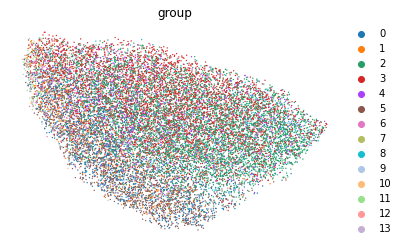

None


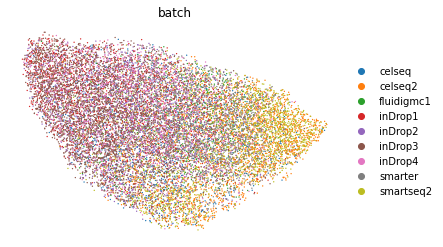

None
Computing NMI ...
Done !
NMI = 0.12643868551342566
Epoch : [1] ,  a_loss = 472.2422, d_loss: inf ,  g_loss: inf,  db_loss: 1.5760
Epoch : [2] ,  a_loss = 697.2698, d_loss: inf ,  g_loss: inf,  db_loss: 2.3873
Epoch : [3] ,  a_loss = 622.2056, d_loss: inf ,  g_loss: inf,  db_loss: 2.0200
Epoch : [4] ,  a_loss = 588.3715, d_loss: inf ,  g_loss: inf,  db_loss: 1.6786
Epoch : [5] ,  a_loss = 443.2778, d_loss: inf ,  g_loss: inf,  db_loss: 2.5073
Epoch : [6] ,  a_loss = 379.6386, d_loss: inf ,  g_loss: inf,  db_loss: 0.6858
Epoch : [7] ,  a_loss = 644.9554, d_loss: inf ,  g_loss: inf,  db_loss: 0.9650
Epoch : [8] ,  a_loss = 361.1646, d_loss: inf ,  g_loss: inf,  db_loss: 0.9487
Epoch : [9] ,  a_loss = 584.2073, d_loss: inf ,  g_loss: inf,  db_loss: 1.7821
Epoch : [10] ,  a_loss = 643.9747, d_loss: inf ,  g_loss: inf,  db_loss: 1.3637
Epoch : [11] ,  a_loss = 596.5416, d_loss: inf ,  g_loss: inf,  db_loss: 2.3067
Epoch : [12] ,  a_loss = 484.6950, d_loss: inf ,  g_loss: inf,  db_loss: 

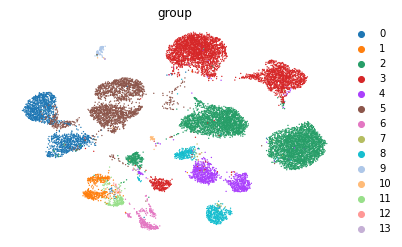

None


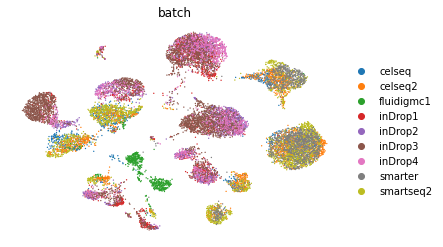

None
Computing NMI ...
Done !
NMI = 0.7763026679095412
Epoch : [51] ,  a_loss = 610.5724, d_loss: inf ,  g_loss: inf,  db_loss: 0.9071
Epoch : [52] ,  a_loss = 606.0385, d_loss: inf ,  g_loss: inf,  db_loss: 1.1797
Epoch : [53] ,  a_loss = 379.3162, d_loss: inf ,  g_loss: inf,  db_loss: 0.7323
Epoch : [54] ,  a_loss = 343.7689, d_loss: inf ,  g_loss: inf,  db_loss: 1.1342
Epoch : [55] ,  a_loss = 311.3701, d_loss: inf ,  g_loss: inf,  db_loss: 0.5672
Epoch : [56] ,  a_loss = 429.9148, d_loss: inf ,  g_loss: inf,  db_loss: 1.5893
Epoch : [57] ,  a_loss = 329.6067, d_loss: inf ,  g_loss: inf,  db_loss: 0.3653
Epoch : [58] ,  a_loss = 431.5230, d_loss: inf ,  g_loss: inf,  db_loss: 1.3740
Epoch : [59] ,  a_loss = 556.0281, d_loss: inf ,  g_loss: inf,  db_loss: 1.1658
Epoch : [60] ,  a_loss = 557.4633, d_loss: inf ,  g_loss: inf,  db_loss: 1.3433
Epoch : [61] ,  a_loss = 307.9495, d_loss: inf ,  g_loss: inf,  db_loss: 1.3755
Epoch : [62] ,  a_loss = 387.3797, d_loss: inf ,  g_loss: inf,  d

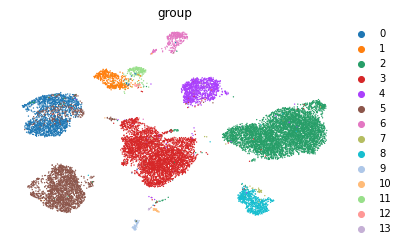

None


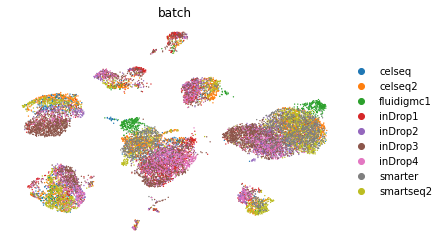

None
Computing NMI ...
Done !
NMI = 0.766099593426373
Epoch : [101] ,  a_loss = 347.9208, d_loss: inf ,  g_loss: inf,  db_loss: 1.7805
Epoch : [102] ,  a_loss = 288.6045, d_loss: inf ,  g_loss: inf,  db_loss: 0.7021
Epoch : [103] ,  a_loss = 422.3128, d_loss: inf ,  g_loss: inf,  db_loss: 2.0860
Epoch : [104] ,  a_loss = 388.9926, d_loss: inf ,  g_loss: inf,  db_loss: 2.1941
Epoch : [105] ,  a_loss = 506.4057, d_loss: inf ,  g_loss: inf,  db_loss: 1.8611
Epoch : [106] ,  a_loss = 437.7590, d_loss: inf ,  g_loss: inf,  db_loss: 1.7248
Epoch : [107] ,  a_loss = 362.9243, d_loss: inf ,  g_loss: inf,  db_loss: 1.8809
Epoch : [108] ,  a_loss = 341.6867, d_loss: inf ,  g_loss: inf,  db_loss: 1.2647
Epoch : [109] ,  a_loss = 370.8667, d_loss: inf ,  g_loss: inf,  db_loss: 2.0995
Epoch : [110] ,  a_loss = 371.5855, d_loss: inf ,  g_loss: inf,  db_loss: 2.3951
Epoch : [111] ,  a_loss = 346.8965, d_loss: inf ,  g_loss: inf,  db_loss: 1.2409
Epoch : [112] ,  a_loss = 328.5118, d_loss: inf ,  g_lo

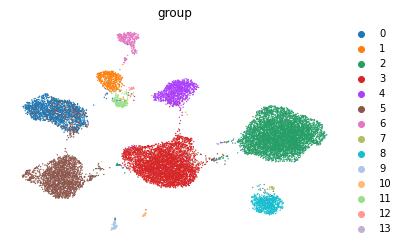

None


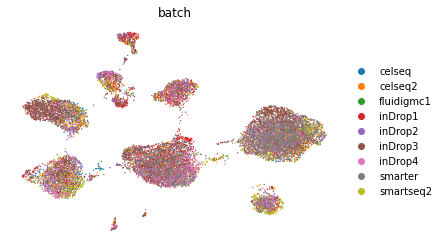

None
Computing NMI ...
Done !
NMI = 0.7715996731623337
Epoch : [151] ,  a_loss = 501.8957, d_loss: inf ,  g_loss: inf,  db_loss: 2.0032
Epoch : [152] ,  a_loss = 368.3166, d_loss: inf ,  g_loss: inf,  db_loss: 2.5562
Epoch : [153] ,  a_loss = 529.8846, d_loss: inf ,  g_loss: inf,  db_loss: 1.9310
Epoch : [154] ,  a_loss = 351.5812, d_loss: inf ,  g_loss: inf,  db_loss: 2.0862
Epoch : [155] ,  a_loss = 482.6656, d_loss: inf ,  g_loss: inf,  db_loss: 2.1878
Epoch : [156] ,  a_loss = 398.2410, d_loss: inf ,  g_loss: inf,  db_loss: 2.3689
Epoch : [157] ,  a_loss = 474.1390, d_loss: inf ,  g_loss: inf,  db_loss: 2.0789
Epoch : [158] ,  a_loss = 357.1622, d_loss: inf ,  g_loss: inf,  db_loss: 2.1112
Epoch : [159] ,  a_loss = 425.2803, d_loss: inf ,  g_loss: inf,  db_loss: 2.5721
Epoch : [160] ,  a_loss = 342.7845, d_loss: inf ,  g_loss: inf,  db_loss: 0.8810
Epoch : [161] ,  a_loss = 339.5121, d_loss: inf ,  g_loss: inf,  db_loss: 1.5550
Epoch : [162] ,  a_loss = 340.0397, d_loss: inf ,  g_l

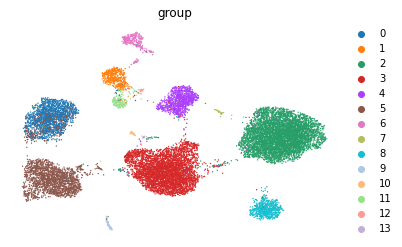

None


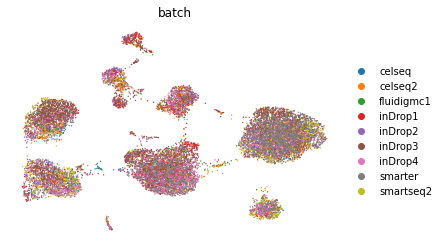

None
Computing NMI ...
Done !
NMI = 0.7782576373964486
Epoch : [201] ,  a_loss = 464.5809, d_loss: inf ,  g_loss: inf,  db_loss: 2.0575
Epoch : [202] ,  a_loss = 528.0833, d_loss: inf ,  g_loss: inf,  db_loss: 2.2207
Epoch : [203] ,  a_loss = 360.6098, d_loss: inf ,  g_loss: inf,  db_loss: 1.6559
Epoch : [204] ,  a_loss = 332.2475, d_loss: inf ,  g_loss: inf,  db_loss: 2.3495
Epoch : [205] ,  a_loss = 503.9324, d_loss: inf ,  g_loss: inf,  db_loss: 2.3041
Epoch : [206] ,  a_loss = 544.2217, d_loss: inf ,  g_loss: inf,  db_loss: 1.7701
Epoch : [207] ,  a_loss = 545.8333, d_loss: inf ,  g_loss: inf,  db_loss: 1.4998
Epoch : [208] ,  a_loss = 334.4999, d_loss: inf ,  g_loss: inf,  db_loss: 1.4702
Epoch : [209] ,  a_loss = 541.2246, d_loss: inf ,  g_loss: inf,  db_loss: 2.1218
Epoch : [210] ,  a_loss = 497.2689, d_loss: inf ,  g_loss: inf,  db_loss: 1.6014
Epoch : [211] ,  a_loss = 364.8474, d_loss: inf ,  g_loss: inf,  db_loss: 1.1489
Epoch : [212] ,  a_loss = 293.1821, d_loss: inf ,  g_l

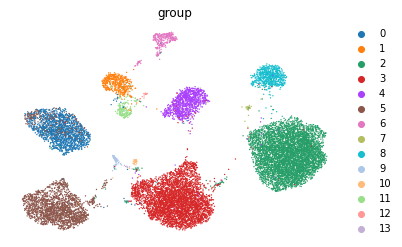

None


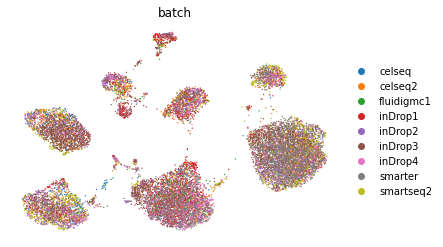

None
Computing NMI ...
Done !
NMI = 0.7775583403891677
Epoch : [251] ,  a_loss = 473.7689, d_loss: inf ,  g_loss: inf,  db_loss: 1.4828
Epoch : [252] ,  a_loss = 522.0247, d_loss: inf ,  g_loss: inf,  db_loss: 1.8176
Epoch : [253] ,  a_loss = 341.5795, d_loss: inf ,  g_loss: inf,  db_loss: 1.8196
Epoch : [254] ,  a_loss = 356.3350, d_loss: inf ,  g_loss: inf,  db_loss: 2.3541
Epoch : [255] ,  a_loss = 494.4339, d_loss: inf ,  g_loss: inf,  db_loss: 1.8726
Epoch : [256] ,  a_loss = 451.0939, d_loss: inf ,  g_loss: inf,  db_loss: 2.8152
Epoch : [257] ,  a_loss = 506.3118, d_loss: inf ,  g_loss: inf,  db_loss: 3.2451
Epoch : [258] ,  a_loss = 499.4088, d_loss: inf ,  g_loss: inf,  db_loss: 2.4428
Epoch : [259] ,  a_loss = 538.9587, d_loss: inf ,  g_loss: inf,  db_loss: 2.4220
Epoch : [260] ,  a_loss = 478.8126, d_loss: inf ,  g_loss: inf,  db_loss: 2.2392
Epoch : [261] ,  a_loss = 404.3649, d_loss: inf ,  g_loss: inf,  db_loss: 2.5739
Epoch : [262] ,  a_loss = 466.0858, d_loss: inf ,  g_l

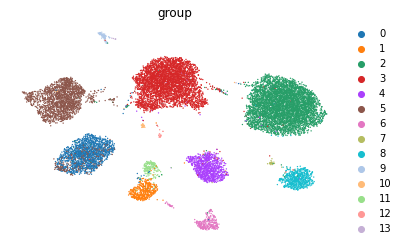

None


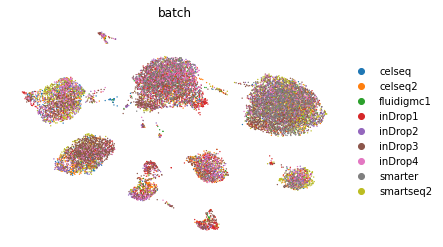

None
Computing NMI ...
Done !
NMI = 0.770827537852391


In [20]:

run_config = tf.ConfigProto()
run_config.gpu_options.per_process_gpu_memory_fraction = 0.333
run_config.gpu_options.allow_growth = True

with tf.Session(config = run_config) as sess:

    g_h_dim = [g_h_l1, g_h_l2, g_h_l3, g_h_l4]
    d_h_dim = [d_h_l1, d_h_l2, d_h_l3, d_h_l4]

    if model == 'dra':
            test_dra = Test_DRA(
                sess,
                epoch = epoch,
                lr = learning_rate,
                beta1 = beta1,
                batch_size = batch_size,
                X_dim = X_dim, 
                z_dim = z_dim,
                dataset_name = dataset,
                checkpoint_dir = checkpoint_dir,
                sample_dir = sample_dir,
                result_dir = result_dir,
                num_layers = n_l,
                g_h_dim = g_h_dim[:n_l],
                d_h_dim = d_h_dim[:n_l],
                gen_activation = actv,
                leak = leak,
                keep_param = keep,
                trans = trans,
                is_bn = bn,
                g_iter = g_iter,
                lam = lam,
                sampler = sampler)

    # show_all_variables()
    if train:
        if model == 'dra':
            test_dra.train_cluster()           

#tf.app.run()

italicized text